In [1]:
import mindquantum as mq
import matplotlib.pyplot as plt
import matplotx
import numpy as np
from scipy.optimize import minimize

In [2]:
def hamil():
    h = mq.QubitOperator('', 5.906709) + \
        mq.QubitOperator('Z0', 0.218291) +\
        mq.QubitOperator('Z1', -6.125) +\
        mq.QubitOperator('X0 X1', -2.143304) +\
        mq.QubitOperator('Y0 Y1', -2.143304)
    return mq.Hamiltonian(h)

In [3]:
print(hamil() )

5.906709 [] +
-2.143304 [X0 X1] +
-2.143304 [Y0 Y1] +
0.218291 [Z0] +
-6.125 [Z1] 


In [4]:
def ansatz():
    T = mq.FermionOperator("0^ 1")
    Tdag = mq.hermitian_conjugated(T)
    qubit_ops = mq.Transform(T-Tdag).jordan_wigner()
    return mq.TimeEvolution(qubit_ops.imag, {'t': 1}).circuit

In [5]:
def hf():
    circ = mq.Circuit()
    circ += mq.X(0)
    return circ

In [6]:
total_circuit = hf() + ansatz()
total_circuit

q0: ──X────RX(π/2)────●──────────────────●────RX(7π/2)───────H───────●─────────────────●───────H──────
                      │                  │                           │                 │
q1: ──H───────────────X────RZ(-1.0*t)────X───────H────────RX(π/2)────X────RZ(1.0*t)────X────RX(7π/2)──

In [7]:
ansatz().params_name

['t']

In [8]:
total_circuit = hf() + ansatz()

In [9]:
def vqe(hamil, total_circuit, init_amp=[0e-1]):
    sim = mq.Simulator("projectq", total_circuit.n_qubits)
    grad_ops = sim.get_expectation_with_grad(hamil, total_circuit,
        ansatz_params_name=ansatz().params_name)
    f, g = grad_ops(np.array(init_amp)) # ansatz parameters need numpy array
    return f[0, 0].real # f is a complex number

In [10]:
def callback(xk, theta_history, expc_list):
    expc_list.append(vqe(hamil(), total_circuit, init_amp=xk))
    theta_history.append(xk[0])
    return None

In [11]:
expc_list = []
theta_history = []
result = minimize(lambda theta: vqe(hamil(), total_circuit, init_amp=theta), [0e-1], callback=lambda xk: callback(xk, theta_history, expc_list))
result

      fun: -1.7491612220155863
 hess_inv: array([[0.03265471]])
      jac: array([-2.98023224e-08])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([0.29713935])

In [12]:
expc_list

[-1.737978455938153,
 -1.7491104642318211,
 -1.7491612220049197,
 -1.7491612220155863]

In [13]:
theta_history

[0.27011126994894935,
 0.2989600551323796,
 0.2971385167094026,
 0.2971393463506486]

In [14]:
import matplotlib as mpl
mpl.rc_file_defaults()

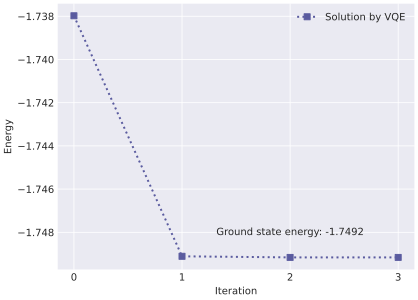

In [15]:
plt.style.use(matplotx.styles.pacoty)
plt.plot(expc_list, linewidth=2, linestyle=':', marker='s', label="Solution by VQE")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.text(2, -1.748, f"Ground state energy: {result.fun:.5}", ha="center", va="center")
plt.xticks(range(len(expc_list)));
plt.savefig("./vqe.pdf")

In [16]:
import scipy.linalg as la

In [17]:
# Pauli matrices
I = np.array([[1, 0],
             [0, 1]])
Sx = np.array([[0, 1],
             [1, 0]])
Sy = np.array([[0, -1j],
             [1j, 0]])
Sz = np.array([[1, 0],
             [0, -1]])

In [18]:
# Build the Hamiltonian
Homl = 5.906709 * np.kron(I, I) +\
        0.218291 * np.kron(I, Sz) +\
        -6.125*np.kron(Sz, I) +\
        -2.143304 * (np.kron(Sx, Sx) + np.kron(Sy, Sy) )

In [19]:
l, v = la.eigh(Homl)

In [20]:
print("The eigenvalues for this Hamiltonian from classical diagonalization are\n", l, sep='')

The eigenvalues for this Hamiltonian from classical diagonalization are
[-1.74916122  0.         11.813418   13.56257922]


<font size=4 face="黑体">
    
    
We see that the ground state energy solved by diagonalization is very close to the solution from vqe.

    
</font>